# Minicurso Classificadores

## Lição 5 - Extra: Classificando Texto

### Reconhecendo spams

#### Importando dependências e setup

In [1]:
# Import datasets, and ML algorithms
from sklearn import datasets, metrics
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Import Numeric library
import numpy as np

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot to be show inside the notebook
%matplotlib inline

# Import data manipulation library
import pandas as pd

# Import function to compose filepath using the current OS directory separator
from os.path import join as path_join

# Import OS identifier
from os import name as os_name

In [2]:
# Set the random seed to reproducibility
import random
random.seed(0)

#### Carregando, Tratando e Explorando os Dados

In [3]:
readme_path = path_join('data','readme.txt')
with open(readme_path, 'r') as myfile:
    print(myfile.read())

SMS Spam Corpus v.0.1
---------------------

1. DESCRIPTION
--------------

The SMS Spam Corpus v.0.1 (hereafter the corpus) is a set of SMS tagged messages that have been collected for SMS Spam research. It contains two collections of SMS messages in English of 1084 and 1319 messages, tagged acording being legitimate (ham) or spam. 

1.1. Compilation
----------------

This corpus has been collected from free or free for research sources at the Web:

- A list of 202 legitimate messages, probably collected by Jon Stevenson, according to the HTML code of the Webpage. Only the text of the messages is available. We will call this corpus the Jon Stevenson Corpus (JSC). It is available at: http://www.demo.inty.net/Units/SMS/corpus.htm
- A subset of the NUS SMS Corpus (NSC), which is a corpus of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from 

In [4]:
import subprocess

filepath = path_join('data', 'english.csv')

if os_name == 'nt':
    get_ipython().system(f'type {filepath}') #  Equivalente to: !type data\english.csv
else:
    get_ipython().system(f'cat {filepath}')

Urgent! call 09061749602 from Landline. Your complimentary 4* Tenerife Holiday or Â£10,000 cash await collection SAE T&Cs BOX 528 HP20 1YF 150ppm 18+;spam
+449071512431 URGENT! This is the 2nd attempt to contact U!U have WON Â£1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. maxÂ£7. 50;spam
FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W45WQ norm150p/tone 16+;spam
Urgent! call 09066612661 from landline. Your complementary 4* Tenerife Holiday or Â£10,000 cash await collection SAE T&Cs PO Box 3 WA14 2PX 150ppm 18+ Sender: Hol Offer;spam
WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.;spam
okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm;spam
0773258

In [5]:
df = pd.read_csv(filepath, sep=';', header=None)
df.head()

,0,1
0,Urgent! call 09061749602 from Landline. Your c...,spam
1,+449071512431 URGENT! This is the 2nd attempt ...,spam
2,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,spam
3,Urgent! call 09066612661 from landline. Your c...,spam
4,WINNER!! As a valued network customer you have...,spam


In [6]:
df.columns = ['text', 'label']
df.tail()

,text,label
1079,So gd got free ice cream... I oso wan...,ham
1080,Same as u... Dun wan... Y u dun like me alread...,ham
1081,Horrible u eat macs eat until u forgot abt me ...,ham
1082,Die... Now i have e toot fringe again...,ham
1083,Horrible bf... I now v hungry...,ham


In [7]:
df.shape

(1084, 2)

In [8]:
df.dtypes

text     object
label    object
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 2 columns):
text     1084 non-null object
label    1084 non-null object
dtypes: object(2)
memory usage: 17.1+ KB


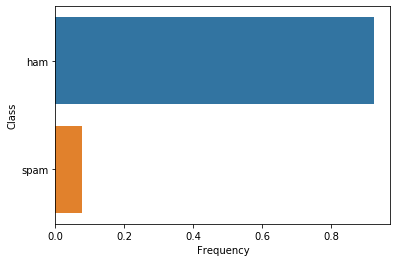

In [10]:
ham_count = len(df.query('label == "ham"').label)
spam_count = len(df.query('label == "spam"').label)

sns.barplot([ham_count/len(df), spam_count/len(df)], ['ham', 'spam']);
plt.xlabel('Frequency');
plt.ylabel('Class');

In [11]:
df.groupby(['label']).agg(['count'])

,text
,count
label,
ham,1002
spam,82


In [12]:
df.iloc[80:-1000]

,text,label
80,Please call our customer service representativ...,spam
81,You are a winner U have been specially selecte...,spam
82,Hey sorry I didntgive ya a a bellearlier hunny...,ham
83,Are you comingdown later?,ham


In [13]:
X = df['text']
X[0]

'Urgent! call 09061749602 from Landline. Your complimentary 4* Tenerife Holiday or £10,000 cash await collection SAE T&Cs BOX 528 HP20 1YF 150ppm 18+'

In [14]:
y = df.label
y[80:-1000]

80    spam
81    spam
82     ham
83     ham
Name: label, dtype: object

#### Definindo o Modelo

In [15]:
model = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())
                 ])
model

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [16]:
scores = cross_validate(model, X, y, cv=10, scoring=['accuracy','f1_macro','f1_weighted'], return_train_score=True)
scores

{'fit_time': array([0.02406359, 0.01503944, 0.01604271, 0.01604295, 0.01704478,
        0.01604271, 0.01704574, 0.01604199, 0.01604271, 0.01604247]),
 'score_time': array([0.01404166, 0.00802159, 0.00802112, 0.0070188 , 0.00701904,
        0.00701833, 0.00601554, 0.00802207, 0.00701904, 0.00701904]),
 'test_accuracy': array([0.97272727, 0.96363636, 0.96296296, 0.9537037 , 0.9537037 ,
        0.94444444, 0.96296296, 0.97222222, 0.93518519, 0.96296296]),
 'train_accuracy': array([0.97741273, 0.97946612, 0.97848361, 0.97540984, 0.97438525,
        0.97643443, 0.97233607, 0.97438525, 0.97643443, 0.97336066]),
 'test_f1_macro': array([0.89268293, 0.84743412, 0.82352941, 0.76053215, 0.76053215,
        0.68543689, 0.82352941, 0.87722622, 0.5942029 , 0.82352941]),
 'train_f1_macro': array([0.90525962, 0.91514645, 0.91156941, 0.89666126, 0.89153965,
        0.90170553, 0.88105673, 0.89153965, 0.90170553, 0.8863388 ]),
 'test_f1_weighted': array([0.97019956, 0.9587946 , 0.95715323, 0.94374641, 

In [17]:
scores_df = pd.DataFrame(scores)
scores_df.mean()*100

fit_time              1.694491
score_time            0.792162
test_accuracy        95.845118
train_accuracy       97.581084
test_f1_macro        78.886356
train_f1_macro       89.825226
test_f1_weighted     94.968312
train_f1_weighted    97.364231
dtype: float64

In [18]:
scores_df.describe()

,fit_time,score_time,test_accuracy,train_accuracy,test_f1_macro,train_f1_macro,test_f1_weighted,train_f1_weighted
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.016945,0.007922,0.958451,0.975811,0.788864,0.898252,0.949683,0.973642
std,0.002565,0.002241,0.011851,0.002264,0.091783,0.010883,0.018437,0.002698
min,0.015039,0.006016,0.935185,0.972336,0.594203,0.881057,0.911075,0.969454
25%,0.016043,0.007019,0.953704,0.974385,0.760532,0.891540,0.943746,0.971957
50%,0.016043,0.007019,0.962963,0.975922,0.823529,0.899183,0.957153,0.973803
75%,0.016794,0.008021,0.963468,0.977168,0.841458,0.904371,0.958384,0.975263
max,0.024064,0.014042,0.972727,0.979466,0.892683,0.915146,0.970200,0.977949


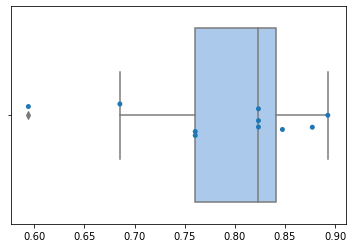

In [19]:
sns.boxplot(scores['test_f1_macro'], palette='pastel');
sns.stripplot(scores['test_f1_macro']);

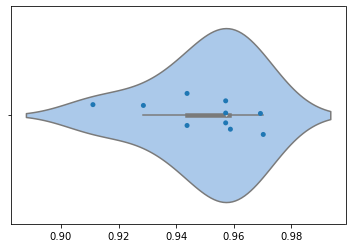

In [20]:
sns.violinplot(scores['test_f1_weighted'], palette='pastel');
sns.stripplot(scores['test_f1_weighted']);

#### Treiando para produção

In [21]:
model.fit(X,y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

#### Prevendo novos textos...

In [22]:
model.predict(['I am not a spam text!'])

array(['ham'], dtype='<U4')

In [23]:
model.predict(["""Urgent! URGENT! Free! FREE! call +449071512431 Holiday £10,000 cash T&Cs
BOX 528 HP20 1YF 150ppm.This is the last attempt to contact U!U have WON Â£1250 CALL 231231.
callcost FREE for 1st week! tell ur mates www.back.co.uk"""])

array(['spam'], dtype='<U4')

---

### Para saber mais...

Dataset:
http://www.esp.uem.es/jmgomez/smsspamcorpus/

Outros datasets para treinar:
- https://www.kaggle.com/datasets
- https://archive.ics.uci.edu/ml/datasets.html

Aprender Pandas:
https://www.kaggle.com/learn/pandas

#### Incrementos sugeridos

- `from sklearn.preprocessing import LabelEncoder`
- `from nltk.corpus import stopwords`
- `from sklearn.externals import joblib`
- https://github.com/pandas-profiling/pandas-profiling

### Dica de execução

Uma forma bem simples de executar este Notebook é usando o Google Colab: https://colab.research.google.com/
(Obs: para realizar a leitura de arquivos no Google Colab é necessário fazer alguns ajustes!)

Se for utilizar sua máquina, lembre de intalar o Python 3 (eu usei o 3.7) e as dependências:
- NumPy
- Scikit-learn
- Jupyter Notebook
- Matplotlib
- Pandas
- Seaborn

Sugiro instalar tanto o python quanto as dependências via [Anaconda](https://www.anaconda.com/distribution/#download-section) ou **[MiniConda](https://conda.io/en/latest/miniconda.html)** criando um Environment.
- https://conda.io/projects/conda/en/latest/user-guide/getting-started.html